# Volatility Surface Construction and Arbitrage Analysis

This notebook provides a comprehensive demonstration of fetching real-world options data for the S&P 500 (SPX), calculating implied volatilities, constructing and visualizing the volatility surface, and performing arbitrage analysis to identify theoretical arbitrage opportunities. The project highlights practical quantitative skills relevant to options pricing, derivatives trading, and risk management.


In [ ]:
## Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf

## Black-Scholes Model
The Black-Scholes formula is used here to price European call options.

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

## Calculating Implied Volatility
The Brent root-finding method is utilized to calculate the implied volatility of options from market prices.

In [ ]:
def implied_volatility(option_price, S, K, T, r):
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - option_price
    try:
        return brentq(objective_function, 1e-6, 5)
    except ValueError:
        return np.nan

## Fetching Real-World Data
Option data is sourced from Yahoo Finance via yfinance API for selected expiry dates.

In [ ]:
spx = yf.Ticker("^SPX")
options_dates = spx.options
expiry_dates = options_dates[:2]

all_options = []
for expiry in expiry_dates:
    opt_chain = spx.option_chain(expiry)
    calls = opt_chain.calls[['strike', 'lastPrice']]
    calls['expiry'] = expiry
    calls['type'] = 'call'
    all_options.append(calls)

options_df = pd.concat(all_options).reset_index(drop=True)

/tmp/ipython-input-4-2487497421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['expiry'] = expiry
/tmp/ipython-input-4-2487497421.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['type'] = 'call'
/tmp/ipython-input-4-2487497421.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

## Preview Data

In [ ]:
options_df.head(10)

,strike,lastPrice,expiry,type,T
0,5400.0,592.23,2025-07-14,call,0.00274
1,5450.0,808.00,2025-07-14,call,0.00274
2,5550.0,486.79,2025-07-14,call,0.00274
3,5600.0,643.87,2025-07-14,call,0.00274
4,5625.0,597.91,2025-07-14,call,0.00274
5,5650.0,636.60,2025-07-14,call,0.00274
6,5700.0,571.73,2025-07-14,call,0.00274
7,5725.0,532.81,2025-07-14,call,0.00274
8,5750.0,513.06,2025-07-14,call,0.00274
9,5775.0,273.99,2025-07-14,call,0.00274


## Data Preparation and Parameters

In [ ]:
current_price = spx.history().iloc[-1]['Close']
risk_free_rate = 0.02  # Example risk-free rate
options_df['expiry'] = pd.to_datetime(options_df['expiry'])
options_df['T'] = (options_df['expiry'] - pd.Timestamp.today()).dt.days / 365

## Computing Implied Volatilities

In [ ]:
options_df['implied_vol'] = options_df.apply(lambda row: implied_volatility(row['lastPrice'], current_price, row['strike'], row['T'], risk_free_rate), axis=1)

## Volatility Surface Visualization
A 3D volatility surface visualizes how implied volatility varies with strike price and time to expiration.

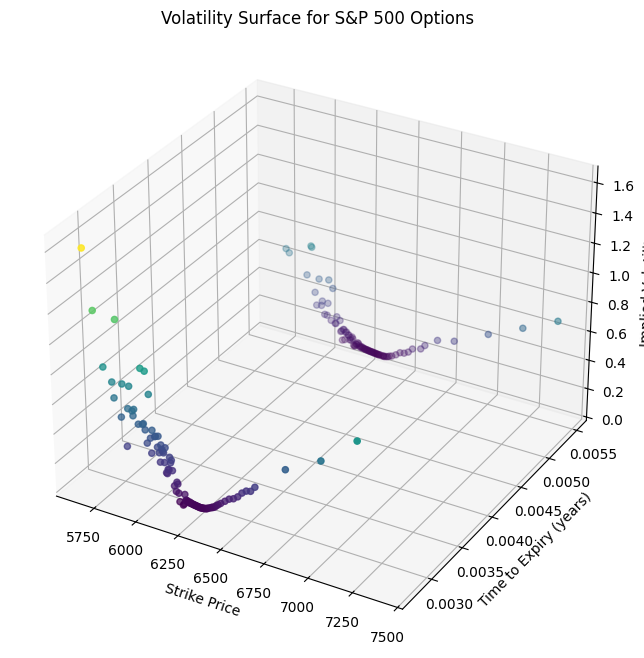

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(options_df['strike'], options_df['T'], options_df['implied_vol'], c=options_df['implied_vol'], cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Time to Expiry (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for S&P 500 Options')
plt.show()

## Arbitrage Analysis
We examine the volatility surface for theoretical arbitrage opportunities, including calendar spread and butterfly spread arbitrage:

In [ ]:
arbitrage_opportunities = []

# Calendar Spread Arbitrage Check
for strike in options_df['strike'].unique():
    subset = options_df[options_df['strike'] == strike].sort_values('T')
    vols = subset['implied_vol'].values
    if len(vols) > 1 and not all(x <= y for x, y in zip(vols, vols[1:])):
        arbitrage_opportunities.append(('Calendar Spread Arbitrage', strike))

# Butterfly Spread Arbitrage Check
strikes_sorted = sorted(options_df['strike'].unique())
for i in range(1, len(strikes_sorted)-1):
    K_low, K_mid, K_high = strikes_sorted[i-1], strikes_sorted[i], strikes_sorted[i+1]
    vols = options_df[options_df['strike'].isin([K_low, K_mid, K_high])].groupby('strike')['implied_vol'].mean()
    if vols[K_mid] > (vols[K_low] + vols[K_high]) / 2:
        arbitrage_opportunities.append(('Butterfly Spread Arbitrage', K_mid))

# Reporting Arbitrage Opportunities
if arbitrage_opportunities:
    print("Arbitrage Opportunities Detected:")
    for arb_type, strike in arbitrage_opportunities:
        print(f"{arb_type} at Strike: {strike}")
else:
    print("No arbitrage opportunities detected.")

Arbitrage Opportunities Detected:
Calendar Spread Arbitrage at Strike: 5625.0
Calendar Spread Arbitrage at Strike: 5650.0
Calendar Spread Arbitrage at Strike: 5700.0
Calendar Spread Arbitrage at Strike: 5800.0
Calendar Spread Arbitrage at Strike: 5840.0
Calendar Spread Arbitrage at Strike: 5850.0
Calendar Spread Arbitrage at Strike: 5860.0
Calendar Spread Arbitrage at Strike: 5870.0
Calendar Spread Arbitrage at Strike: 5875.0
Calendar Spread Arbitrage at Strike: 5880.0
Calendar Spread Arbitrage at Strike: 5890.0
Calendar Spread Arbitrage at Strike: 5900.0
Calendar Spread Arbitrage at Strike: 5910.0
Calendar Spread Arbitrage at Strike: 5920.0
Calendar Spread Arbitrage at Strike: 5930.0
Calendar Spread Arbitrage at Strike: 5940.0
Calendar Spread Arbitrage at Strike: 5950.0
Calendar Spread Arbitrage at Strike: 5960.0
Calendar Spread Arbitrage at Strike: 5970.0
Calendar Spread Arbitrage at Strike: 5975.0
Calendar Spread Arbitrage at Strike: 5980.0
Calendar Spread Arbitrage at Strike: 5990.

## Conclusion
This notebook provides a foundational approach for practical volatility surface modeling and arbitrage detection, demonstrating essential techniques and analytical rigor that are highly valued in quantitative finance roles.
